<a href="https://colab.research.google.com/github/emicervantes/Math-199/blob/main/skm_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Week 10: SKM Experiments**

Main Problem: Finding optimized threshold for Residual SKM and Dynamic Range SKM

* Experiment 1: Finding optimized residual threshold for Residual SKM. (At which point do we switch to SKM?)

* Experiment 2: Finding optimized dynamic range for Dynamic Range SKM. (At which point do we switch to SKM?)

* Experiment 3: Finding efficient method compared to SKM, Residual SKM, and Dynamic Range SKM using matrices with different sizes.

## Defining Functions

In [ ]:
import numpy as np
from numpy import linalg as LA
from time import process_time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
import random, math
from scipy import sparse 
from scipy.sparse import random
from scipy import stats
from numpy.random import default_rng

### Residual, Approximation Error, FLOP Rate Calculation Functions

In [ ]:
def calculate_resid(A,x,b):
  r = (np.linalg.norm(np.matmul(A,x)-b))**2
  return r

def calculate_ap(Xk,Xnew):
  e = (np.linalg.norm(Xk-Xnew))**2
  return e

def calc_FLOP(iteration, cond, rand_flop_rate, skm_flop_rate):
  flop = [0];
  for i in range(iteration):
    if cond[i] == "RK":
      flop.append(flop[-1] + rand_flop_rate)
    else:
      flop.append(flop[-1] + skm_flop_rate)

  return flop

### RK

In [ ]:
def kacz_rand(A, b, X0, X, TOL):
  m,n = np.shape(A)
  Xk = X0
  X_list = [Xk]
  resid_errors = []
  approx_errors = []
  resid_list = []
  k = 0 
  iterations = 0

  while True:
    p = (LA.norm(A, axis = 1) / LA.norm(A))**2
    i = np.random.choice(range(m), p = p)
    ai = A[i,:]
    c = ((ai@Xk - b[i])/ LA.norm(ai)**2).item()
    X_new = Xk - c * np.transpose(ai)
    resid_list.append(A@X_new - b)
    X_list.append(X_new)
    Xk = X_new
    resid_errors.append(LA.norm(np.matmul(A,Xk)- b)**2)
    approx_errors.append(LA.norm(Xk - X)**2)

    iterations = iterations + 1
    
    if LA.norm(np.matmul(A,Xk)- b)**2 < TOL:
      break

  return X_list, resid_errors, iterations, approx_errors, resid_list

### SKM Function (Q and non-Q)

In [ ]:
# SKM function 
def SKM_greedy(A, x, b, beta, TOL):
  k=0 # for iteration count
  m,n = A.shape
  X_old = np.zeros(n)
  X = [X_old]
  r_error = [LA.norm(-b)**2]
  ap_error = []

  while True:
    r = []
    p = (np.linalg.norm(A) / np.linalg.norm(A))**2
    i_sub = np.random.choice(m, size = beta, replace = False)
    for i in i_sub:
      resid = np.transpose(A[i,:])@X_old - b[i]
      r.append([i,np.abs(resid)])
    [i,r] = max(r,key = lambda x : x[1])
    ai = A[i,:]

    X_new = X_old - ((ai @ X_old - b[i]) / np.linalg.norm(ai)**2) * np.transpose(ai)

    X.append(X_new)
    r = calculate_resid(A, X_new, b)
    r_error.append(r)
    X_old = X_new
    e = calculate_ap(X_old, x)
    ap_error.append(e)
    k+=1
    if r < TOL or e < TOL:
      break
  return r_error, ap_error, k, X

# SKM function (Using Q)
def SKMQ_greedy(A, x, b, beta, TOL):
  k=0 # for iteration count
  m,n = A.shape
  Xk = np.zeros(n)
  X = [Xk]
  r_error = [-b]
  Nr_error = [LA.norm(-b)**2]
  ap_error = []
  Q = A@np.transpose(A)

  while True:
    r = []
    p = (np.linalg.norm(A) / np.linalg.norm(A))**2
    i_sub = np.random.choice(m, size = beta, replace = False)
    for i in i_sub:
      resid = np.transpose(A[i,:])@Xk - b[i]
      r.append([i,np.abs(resid)])
    [i,r] = max(r,key = lambda x : x[1])
    ai = A[i,:]

    c = ((ai@Xk - b[i])/ LA.norm(ai)**2).item()
    X_new = Xk - c * np.transpose(ai)
    X.append(X_new)
    Xk = X_new
    r_error.append(r_error[k] - c * Q[i])
    e = calculate_ap(Xk, x)
    ap_error.append(e)
    k+=1

    Nr_error.append(LA.norm(r_error[k] - c * Q[i])**2)
    if Nr_error[-1] < TOL or e < TOL:
      break
       

  return r_error, ap_error, k, X, Nr_error

### Dynamic Range SKM (Q and non-Q)

In [ ]:
def dynamic_SKM(A, x, b, beta, dynTOL, TOL):

  # initialize values
  m,n = np.shape(A)
  Xk = np.zeros(n)
  X_list = [Xk]
  resid_list = []
  Nresid_list = [LA.norm(-b)**2]
  dynamic_range = [LA.norm(-b)**2 / max(np.abs(-b))**2]
  approx_errors = []
  cond_status = []
  k = 0 

  while True:
    ## Randomized Kaczmarz Method
    if np.abs(dynamic_range[k]) > dynTOL: # condition with dynamic range:
      p = (LA.norm(A, axis = 1) / LA.norm(A))**2
      i = np.random.choice(range(m), p = p)
      ai = A[i,:]
      cond_status.append("RK")
    
    ## SKM
    else:
      i_sub = np.random.choice(m, size = beta, replace = False)
      r = []
      for i in i_sub:
        resid = np.transpose(A[i,:])@Xk - b[i]
        r.append([i,np.abs(resid)])
      [i,r] = max(r,key = lambda x : x[1])
      ai = A[i,:]
      cond_status.append("SKM")

    c = ((ai@Xk - b[i])/ LA.norm(ai)**2).item()
    X_new = Xk - c * np.transpose(ai)
    X_list.append(X_new)
    Xk = X_new
    #resid_list.append(A@Xk - b)
    approx_errors.append(LA.norm(Xk - x)**2)
    dynamic_range.append(LA.norm(A@Xk - b)**2 / max(np.abs(A@Xk - b)**2))

    k = k + 1

    Nresid_list.append(LA.norm(A@Xk - b)**2)
    if Nresid_list[-1] < TOL:
        break

  return X_list, resid_list, k, approx_errors, dynamic_range, cond_status, Nresid_list

def dynamicQ_SKM(A, x, b, beta, dynTOL, TOL):

  # initialize values
  m,n = np.shape(A)
  Xk = np.zeros(n)
  X_list = [Xk]
  residQ_errors = [-b]
  Nresid_list = [LA.norm(-b)**2]
  dynamic_range = [LA.norm(-b)**2 / max(np.abs(-b))**2]
  approx_errors = []
  cond_status = []
  k = 0 
  Q = A@np.transpose(A)

  while True:
    ## Randomized Kaczmarz Method
    if np.abs(dynamic_range[k]) > dynTOL: # condition with dynamic range:
      p = (LA.norm(A, axis = 1) / LA.norm(A))**2
      i = np.random.choice(range(m), p = p)
      ai = A[i,:]
      cond_status.append("RK")
    
    ## SKM
    else:
      i_sub = np.random.choice(m, size = beta, replace = False)
      r = []
      for i in i_sub:
        resid = np.transpose(A[i,:])@Xk - b[i]
        r.append([i,np.abs(resid)])
      [i,r] = max(r,key = lambda x : x[1])
      ai = A[i,:]
      cond_status.append("SKM")

    c = ((ai@Xk - b[i])/ LA.norm(ai)**2).item()
    X_new = Xk - c * np.transpose(ai)
    X_list.append(X_new)
    Xk = X_new
    residQ_errors.append(residQ_errors[k] - c * Q[i])
    approx_errors.append(LA.norm(Xk - x)**2)
    dynamic_range.append(LA.norm(residQ_errors[k] - c * Q[i])**2 / max(np.abs(residQ_errors[k] - c * Q[i])**2))

    k = k + 1

    Nresid_list.append(LA.norm(residQ_errors[-1])**2)
    if Nresid_list[-1] < TOL:
        break

  return X_list, residQ_errors, k, approx_errors, dynamic_range, cond_status, Nresid_list


In [ ]:
def dynamic_SKM2(A, x, b, beta, dynTOL, TOL):

  # initialize values
  m,n = np.shape(A)
  Xk = np.zeros(n)
  X_list = [Xk]
  resid_list = []
  Nresid_list = [LA.norm(-b)**2]
  dynamic_range = [LA.norm(-b)**2 / max(np.abs(-b))**2]
  approx_errors = []
  cond_status = []
  k = 0 

  while True:
    ## Randomized Kaczmarz Method
    if  dynTOL[0] >= np.abs(dynamic_range[k]) >= dynTOL[1]: # condition with dynamic range:
      p = (LA.norm(A, axis = 1) / LA.norm(A))**2
      i = np.random.choice(range(m), p = p)
      ai = A[i,:]
      cond_status.append("RK")
    
    ## SKM
    else:
      i_sub = np.random.choice(m, size = beta, replace = False)
      r = []
      for i in i_sub:
        resid = np.transpose(A[i,:])@Xk - b[i]
        r.append([i,np.abs(resid)])
      [i,r] = max(r,key = lambda x : x[1])
      ai = A[i,:]
      cond_status.append("SKM")

    c = ((ai@Xk - b[i])/ LA.norm(ai)**2).item()
    X_new = Xk - c * np.transpose(ai)
    X_list.append(X_new)
    Xk = X_new
    #resid_list.append(A@Xk - b)
    approx_errors.append(LA.norm(Xk - x)**2)
    dynamic_range.append(LA.norm(A@Xk - b)**2 / max(np.abs(A@Xk - b)**2))

    k = k + 1

    Nresid_list.append(LA.norm(A@Xk - b)**2)
    if Nresid_list[-1] < TOL:
        break

  return X_list, resid_list, k, approx_errors, dynamic_range, cond_status, Nresid_list

def dynamicQ_SKM2(A, x, b, beta, dynTOL, TOL):

  # initialize values
  m,n = np.shape(A)
  Xk = np.zeros(n)
  X_list = [Xk]
  residQ_errors = [-b]
  Nresid_list = [LA.norm(-b)**2]
  dynamic_range = [LA.norm(-b)**2 / max(np.abs(-b))**2]
  approx_errors = []
  cond_status = []
  k = 0 
  Q = A@np.transpose(A)

  while True:
    ## Randomized Kaczmarz Method
    if dynTOL[0] >= np.abs(dynamic_range[k]) >= dynTOL[1]: # condition with dynamic range:
      p = (LA.norm(A, axis = 1) / LA.norm(A))**2
      i = np.random.choice(range(m), p = p)
      ai = A[i,:]
      cond_status.append("RK")
    
    ## SKM
    else:
      i_sub = np.random.choice(m, size = beta, replace = False)
      r = []
      for i in i_sub:
        resid = np.transpose(A[i,:])@Xk - b[i]
        r.append([i,np.abs(resid)])
      [i,r] = max(r,key = lambda x : x[1])
      ai = A[i,:]
      cond_status.append("SKM")

    c = ((ai@Xk - b[i])/ LA.norm(ai)**2).item()
    X_new = Xk - c * np.transpose(ai)
    X_list.append(X_new)
    Xk = X_new
    residQ_errors.append(residQ_errors[k] - c * Q[i])
    approx_errors.append(LA.norm(Xk - x)**2)
    dynamic_range.append(LA.norm(residQ_errors[k] - c * Q[i])**2 / max(np.abs(residQ_errors[k] - c * Q[i])**2))

    k = k + 1

    Nresid_list.append(LA.norm(residQ_errors[-1])**2)
    if Nresid_list[-1] < TOL:
        break

  return X_list, residQ_errors, k, approx_errors, dynamic_range, cond_status, Nresid_list

### Residual Vector SKM (Q and non-Q)

In [ ]:
def resid_SKM(A, x, b, beta, residTOL, TOL):
  
  # initialize values
  m,n = np.shape(A)
  Xk = np.zeros(n)
  X_list = [Xk]
  resid_list = [-b]
  Nresid_list = [LA.norm(-b)**2]
  approx_errors = []
  cond_status = []
  k = 0 

  while True:
    ## Randomized Kaczmarz Method
    if np.count_nonzero(np.array(resid_list[-1]) > residTOL) < n/2: # condition with residual vector
      p = (LA.norm(A, axis = 1) / LA.norm(A))**2
      i = np.random.choice(range(m), p = p)
      ai = A[i,:]
      cond_status.append("RK")
    
    ## SKM
    else:
      i_sub = np.random.choice(m, size = beta, replace = False)
      r = []
      for i in i_sub:
        resid = np.transpose(A[i,:])@Xk - b[i]
        r.append([i,np.abs(resid)])
      [i,r] = max(r,key = lambda x : x[1])
      ai = A[i,:]
      cond_status.append("SKM")

    c = ((ai@Xk - b[i])/ LA.norm(ai)**2).item()
    X_new = Xk - c * np.transpose(ai)
    X_list.append(X_new)
    Xk = X_new
    approx_errors.append(LA.norm(Xk - x)**2)
    resid_list.append(A@Xk - b)

    k = k + 1

    Nresid_list.append(LA.norm(A@Xk - b)**2)
    if Nresid_list[-1] < TOL:
        break

  return X_list, resid_list, k, approx_errors, cond_status, Nresid_list

def residQ_SKM(A, x, b, beta, residTOL, TOL):
  
  # initialize values
  m,n = np.shape(A)
  Xk = np.zeros(n)
  X_list = [Xk]
  residQ_errors = [-b]
  Nresid_list = [LA.norm(-b)**2]
  approx_errors = []
  cond_status = []
  k = 0 
  Q = A@np.transpose(A)

  while True:
    ## Randomized Kaczmarz Method
    if np.count_nonzero(np.array(residQ_errors[-1]) > residTOL) < n/2: # condition with residual vector
      p = (LA.norm(A, axis = 1) / LA.norm(A))**2
      i = np.random.choice(range(m), p = p)
      ai = A[i,:]
      cond_status.append("RK")
    
    ## SKM
    else:
      i_sub = np.random.choice(m, size = beta, replace = False)
      r = []
      for i in i_sub:
        resid = np.transpose(A[i,:])@Xk - b[i]
        r.append([i,np.abs(resid)])
      [i,r] = max(r,key = lambda x : x[1])
      ai = A[i,:]
      cond_status.append("SKM")

    c = ((ai@Xk - b[i])/ LA.norm(ai)**2).item()
    X_new = Xk - c * np.transpose(ai)
    X_list.append(X_new)
    Xk = X_new
    residQ_errors.append(residQ_errors[k] - c * Q[i])
    approx_errors.append(LA.norm(Xk - x)**2)

    k = k + 1

    Nresid_list.append(LA.norm(residQ_errors[k] - c * Q[i])**2)
    if Nresid_list[-1] < TOL:
        break

  return X_list, residQ_errors, k, approx_errors, cond_status, Nresid_list

## Matrix for evaluation

In [ ]:
A = np.random.randn(500,250)
X = np.random.randn(250)
b = A @ X
m,n = A.shape

# Regular SKM

In [ ]:
SKM_cond = []
SKMQ_cond = []

t3_start_cyclic = process_time()
SKM_result = SKM_greedy(A, X, b, 100, 0.1)
t3_stop_cyclic = process_time()

t4_start_cyclic = process_time()
SKMQ_result = SKMQ_greedy(A, X, b, 100, 0.1)
t4_stop_cyclic = process_time()

SKM_CPU = t3_stop_cyclic - t3_start_cyclic
SKM_error = SKM_result[0]
SKMIter = SKM_result[2]
for i in range(SKMIter):
  SKM_cond.append("SKM")
SKM_flop = calc_FLOP(SKM_result[2], SKM_cond, m, 100*m + m)

SKMQ_CPU = t4_stop_cyclic - t4_start_cyclic
SKMQ_error = SKMQ_result[4]
SKMQIter = SKMQ_result[2]
for i in range(SKMQIter):
  SKMQ_cond.append("SKM")
SKMQ_flop = calc_FLOP(SKMQ_result[2], SKMQ_cond, m, n + m)

# Experiment 1: Residual Vector SKM

We want to find the optimized residual threshold value for Residual SKM. Find the best value of `r` such that if the majority of rows have values less than or equal to `r`, then we switch the algorithm from RK to SKM.

First, we will find the distribution of number of rows that have value less than or equal to `r`

Residual distribution of RK



In [ ]:
# Solving system with RK
RK_result = kacz_rand(A, b, X0, X, 0.1)
iteration = RK_result[2]
residual = RK_result[4]
norm_resid = RK_result[1]

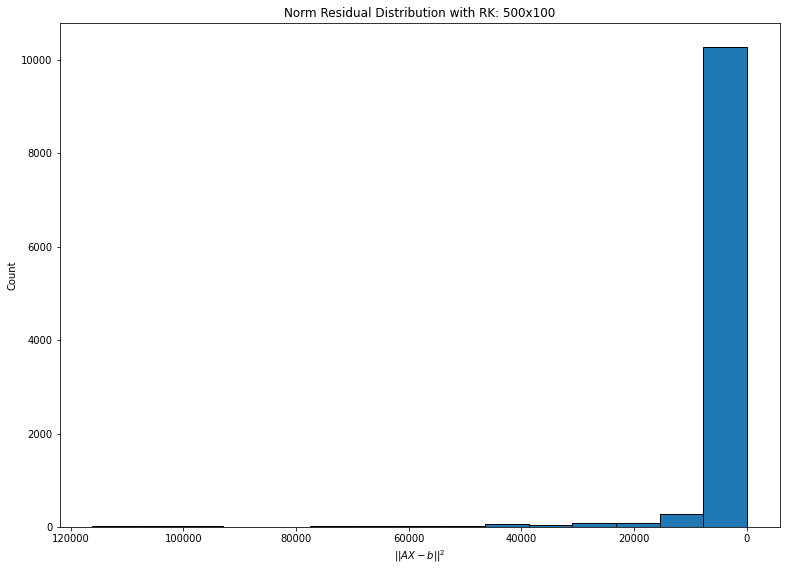

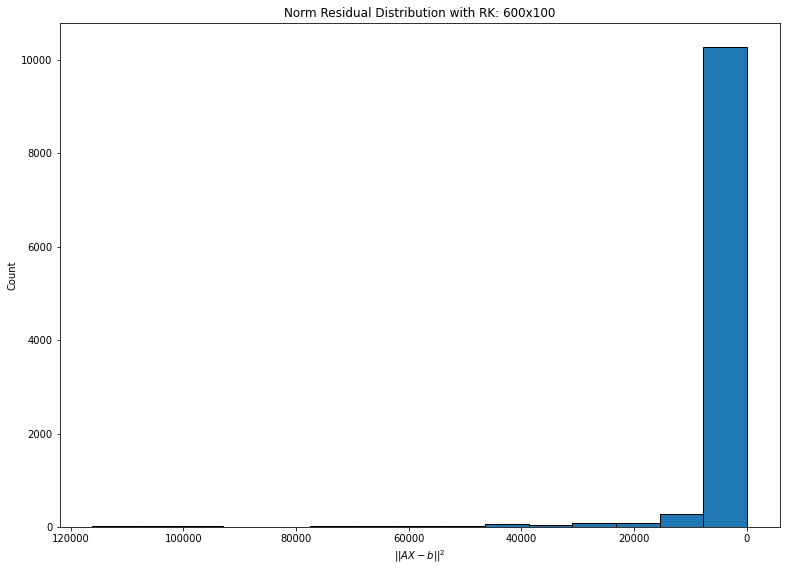

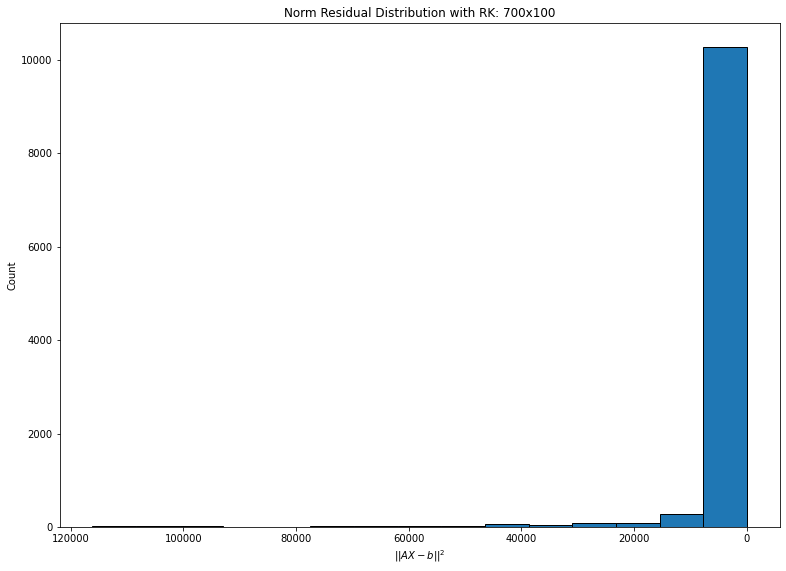

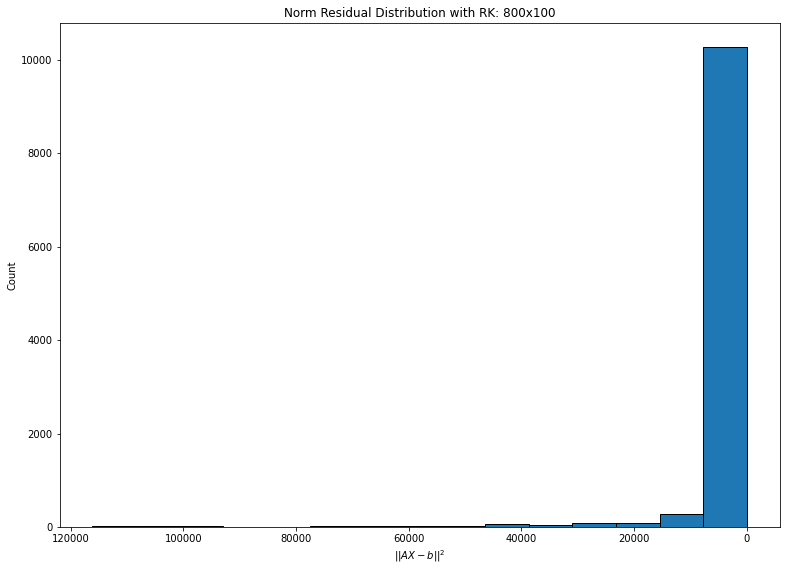

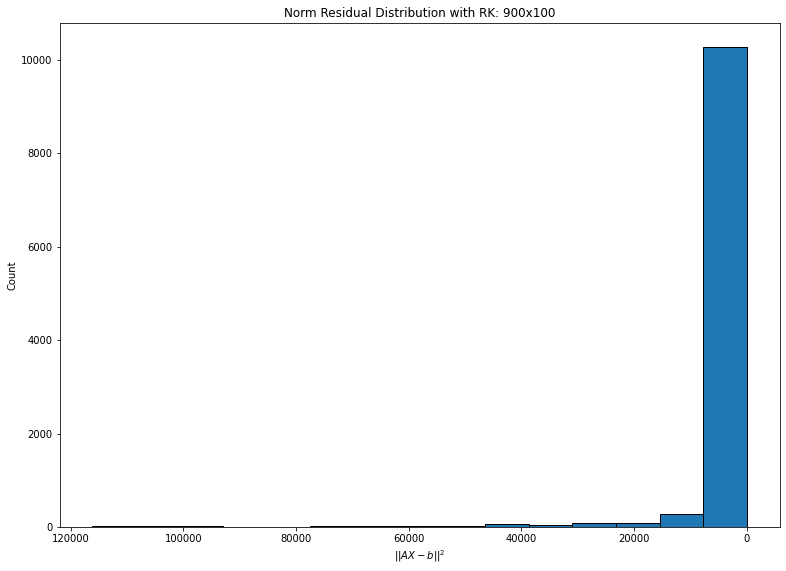

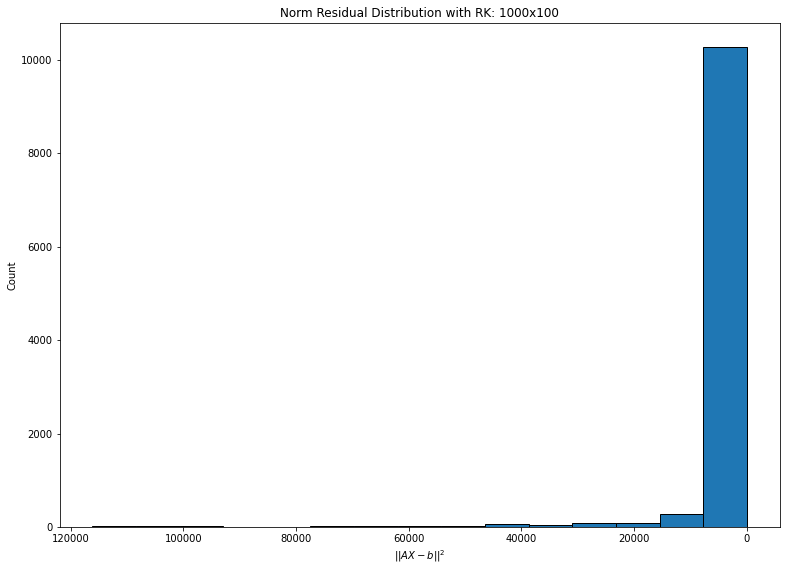

In [ ]:
for i in [[500,100],[600,100],[700,100],[800,100],[900,100], [1000,100]]:
  A = np.random.randn(i[0],i[1])
  x = np.random.randn(i[1])
  b = A @ x
  X0 = np.zeros(i[1])

  RK_result = kacz_rand(A,b,X0,x,0.1)
  norm_residual = RK_result[1]

  fig = plt.figure(figsize =(10, 7))
  ax = fig.add_axes([0, 0, 1, 1])
  plt.hist(norm_resid, bins = 15, edgecolor = 'black')
  ax.set_xlim(ax.get_xlim()[::-1])
  plt.xlabel("$||AX-b||^2$")
  plt.ylabel("Count")
  plt.title("Norm Residual Distribution with RK: " + str(i[0]) + "x" + str(i[1]))
  plt.show()

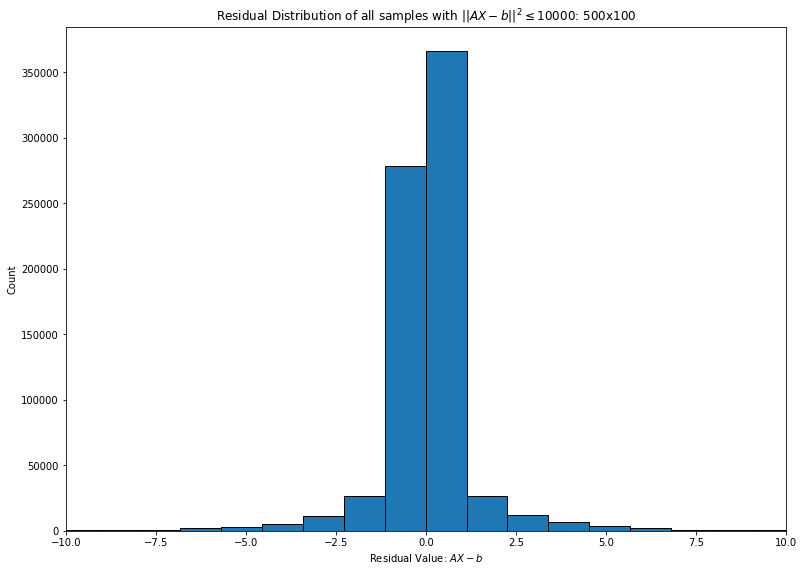

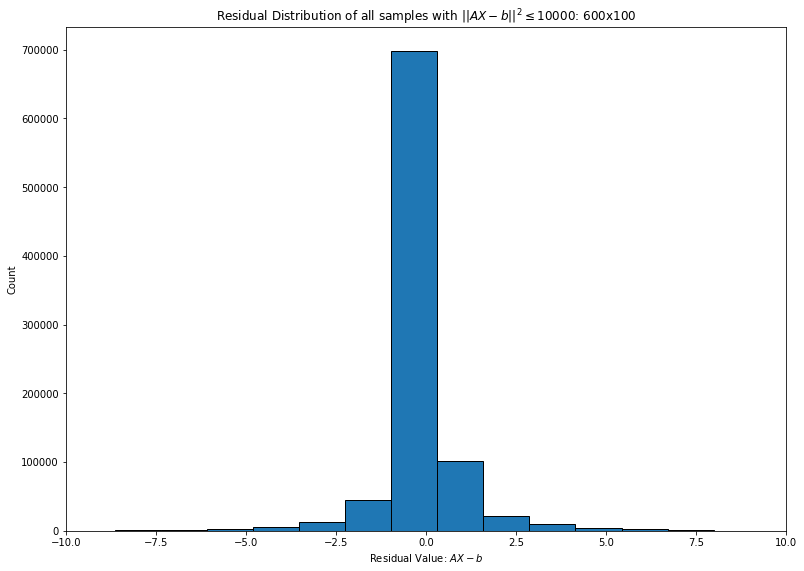

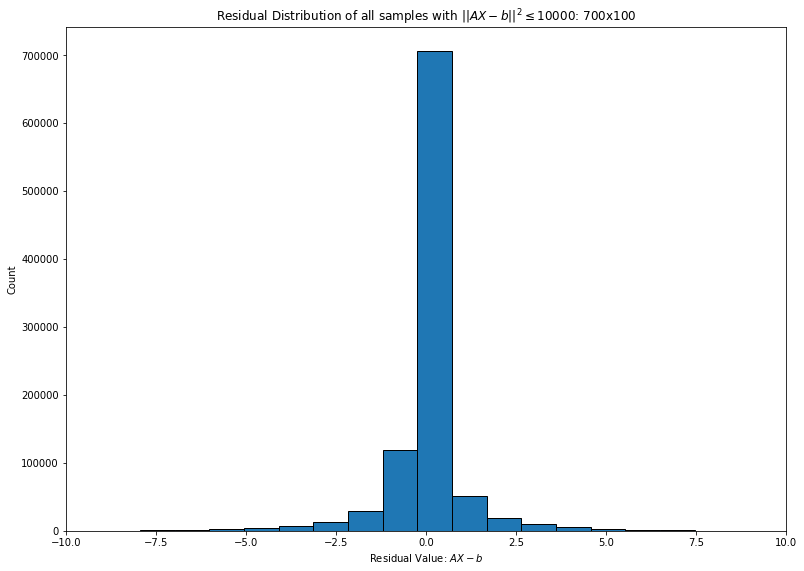

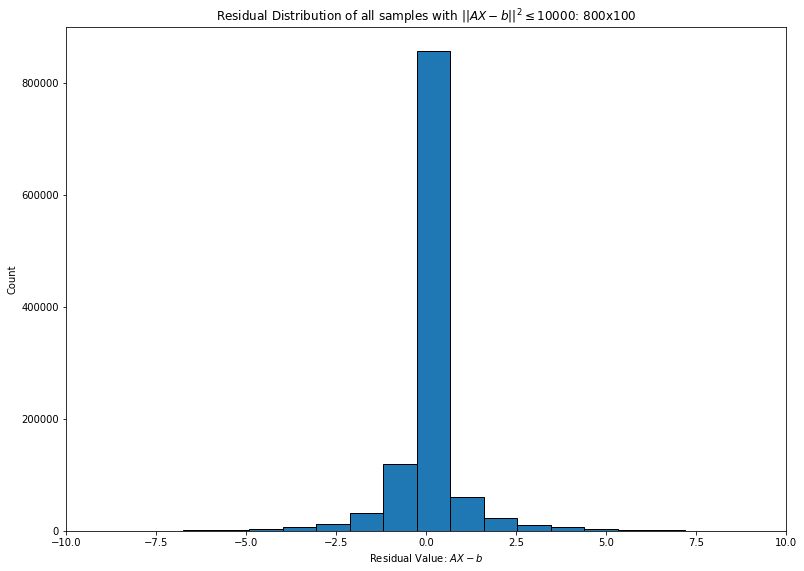

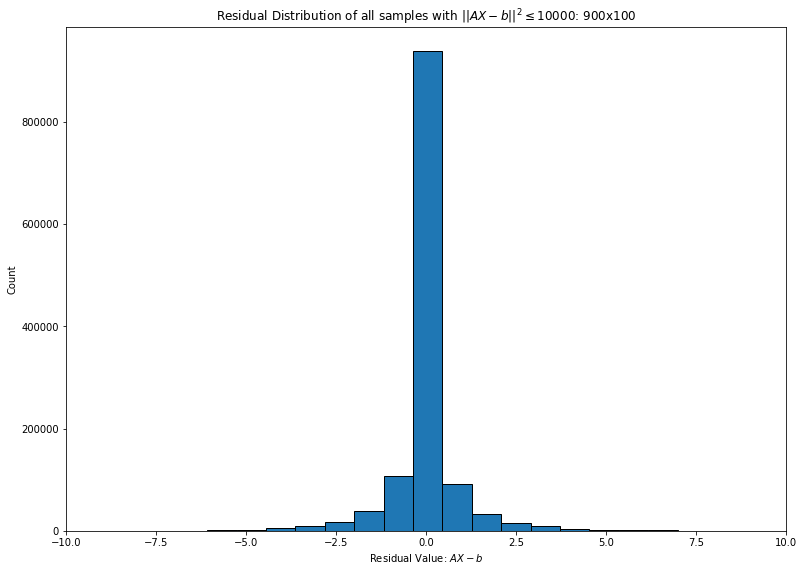

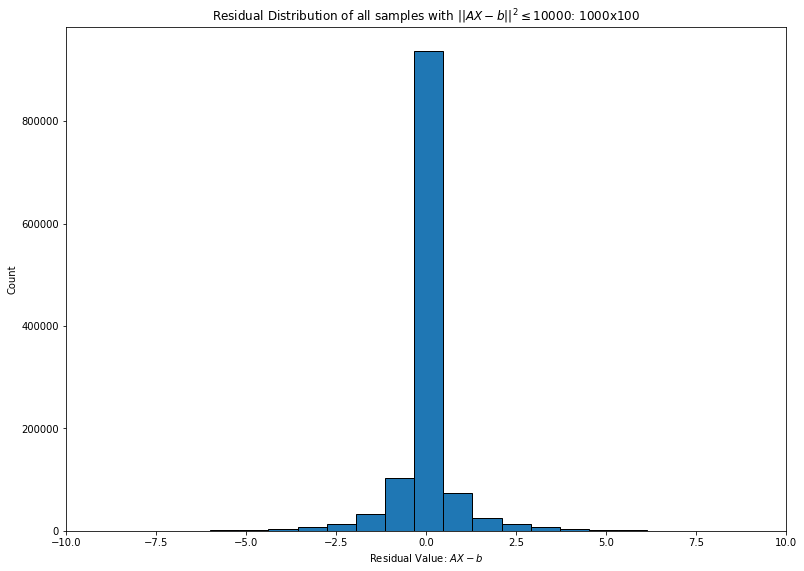

In [ ]:
for i in [[500,100],[600,100],[700,100],[800,100],[900,100], [1000,100]]:
  A = np.random.randn(i[0],i[1])
  x = np.random.randn(i[1])
  b = A @ x
  X0 = np.zeros(i[1])

  RK_result = kacz_rand(A,b,X0,x,0.1)
  norm_residual = RK_result[1]
  iteration = RK_result[2]
  residual = RK_result[4]
  new_residual_list = []
  for j in range(iteration):
    if norm_residual[j] <= 10000:
      new_residual_list.append(residual[j])
  np_resid = np.array(new_residual_list)
  np_resid = np_resid.flatten()

  fig = plt.figure(figsize =(10, 7))
  ax = fig.add_axes([0, 0, 1, 1])
  plt.hist(np_resid, bins = 25, edgecolor = 'black')
  plt.xlim([-10, 10])
  plt.xlabel("Residual Value: $AX - b$")
  plt.ylabel("Count")
  plt.title("Residual Distribution of all samples with $||AX-b||^2 \leq 10000$: " + str(i[0]) + "x" + str(i[1]))
  plt.show()

We first noticed most of our data we tested had norm residual error that is less than or equal to 10000. We then looked at residual distribution of all data that had norm residual value that is less than or equal to 10000. We plotted histogram for matrices with different dimension. We observed that
approximate mean of residual is in $[-1,1]$, with approximate minimum value = -5 and approximate maximum value = 5. 

Suggesetions:
* Take absolute value of residual when comparing the value with `r`
* Test residual vector SKM with each r in `r = [1,2,3,4,5]`
* Possibly add smaller values in $(0,1]$ due to the distribution mean

In [ ]:
residQ_error = []
resid_error = []
residQIter = []
residIter = []
residQCPU = []
residCPU = []
residQ_flop = []
resid_flop = []

for TOL in [1,2,3,4,5]:

  t1_start_cyclic = process_time()
  residQ_result = residQ_SKM(A, X, b, 100, TOL, 0.1)
  t1_stop_cyclic = process_time()


  t2_start_cyclic = process_time()
  resid_result = resid_SKM(A, X, b, 100, TOL, 0.1)
  t2_stop_cyclic = process_time()

  residQCPU.append(t1_stop_cyclic - t1_start_cyclic)
  residQ_error.append(residQ_result[5])
  residQIter.append(residQ_result[2])
  residQ_flop.append(calc_FLOP(residQ_result[2], residQ_result[4], m, n + m))

  residCPU.append(t2_stop_cyclic - t2_start_cyclic)
  resid_error.append(resid_result[5])
  residIter.append(resid_result[2])
  resid_flop.append(calc_FLOP(resid_result[2], resid_result[4], m, 100*m + m))

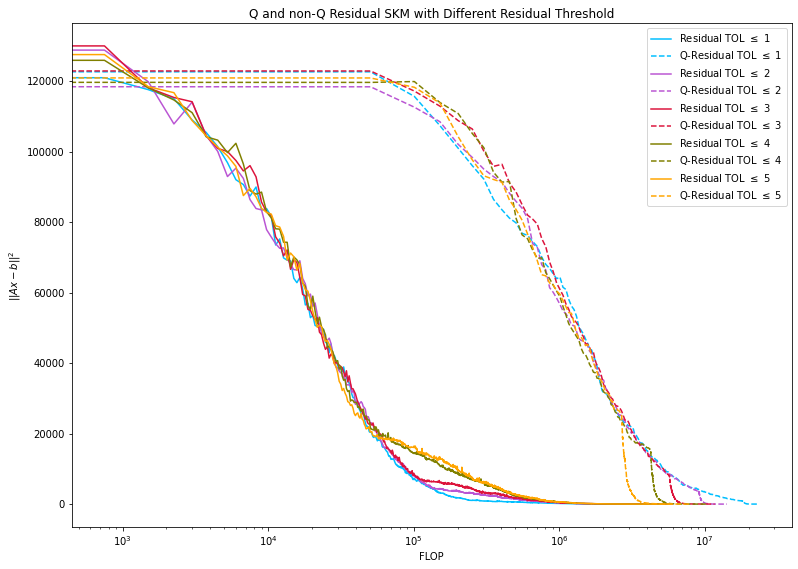

In [ ]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
residTOL = [1,2,3,4,5]
c = ["deepskyblue","mediumorchid","crimson","olive","orange"]
for i in range(5):
  plt.semilogx(residQ_flop[i], residQ_error[i], color = c[i], label = f"Residual TOL $\leq$ {residTOL[i]}")
  plt.semilogx(resid_flop[i], resid_error[i], linestyle='dashed', color = c[i], label = f"Q-Residual TOL $\leq$ {residTOL[i]}")
plt.legend()
plt.title("Q and non-Q Residual SKM with Different Residual Threshold")
plt.xlabel("FLOP")
plt.ylabel("$||Ax - b||^2$")
plt.show()

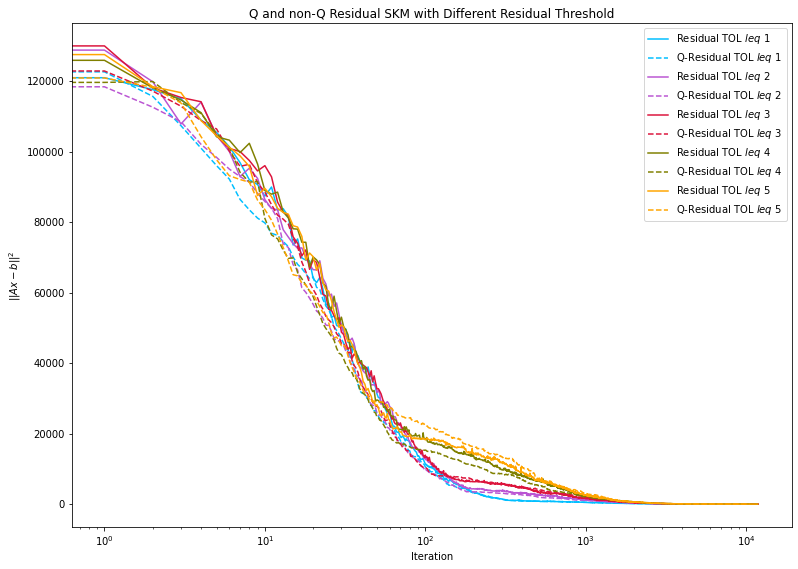

In [ ]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
residTOL = [1,2,3,4,5]
c = ["deepskyblue","mediumorchid","crimson","olive","orange"]
for i in range(5):
  plt.semilogx(list(range(residQIter[i]+1)), residQ_error[i], color = c[i], label = f"Residual TOL $leq$ {residTOL[i]}")
  plt.semilogx(list(range(residIter[i]+1)), resid_error[i], linestyle='dashed', color = c[i], label = f"Q-Residual TOL $leq$ {residTOL[i]}")
plt.legend()
plt.title("Q and non-Q Residual SKM with Different Residual Threshold")
plt.xlabel("Iteration")
plt.ylabel("$||Ax - b||^2$")
plt.show()

# Experiment 2: Dynamic Range SKM

We want to find the optimized value of dynamic range for the Dynamic Range SKM. When do we switch to SKM?

Approaches:

* Plot dynamic range distribution of RK

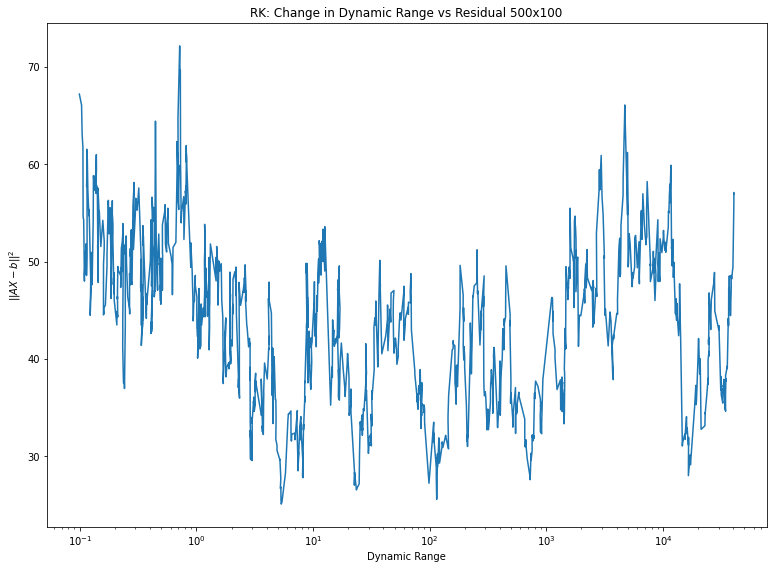

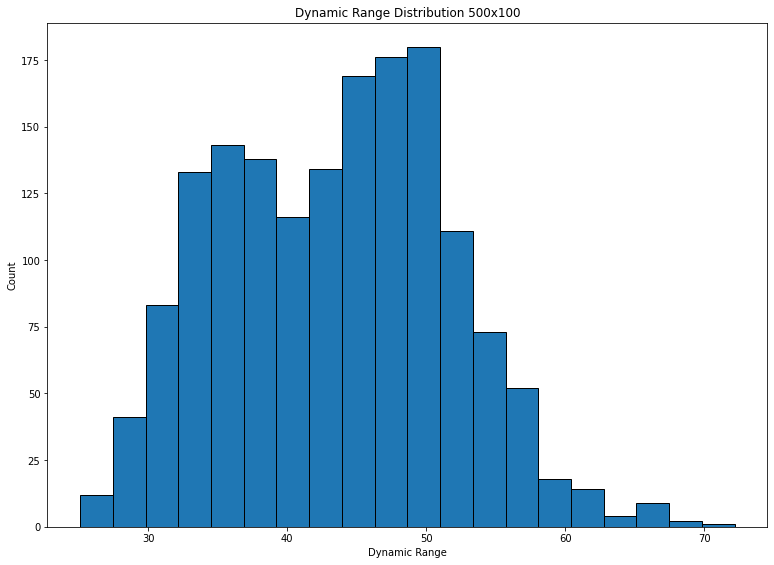

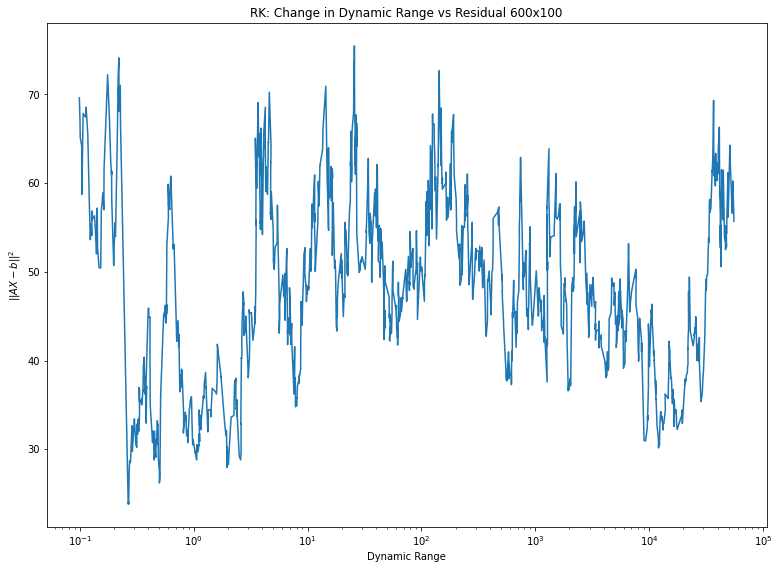

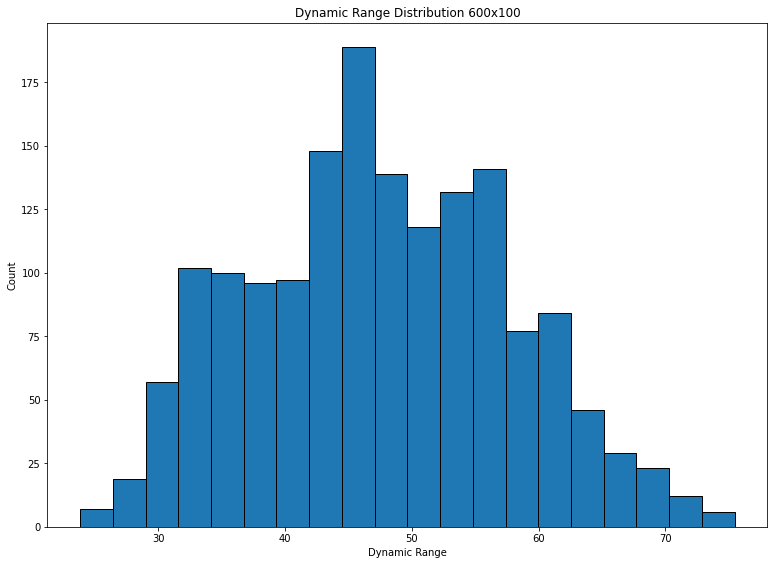

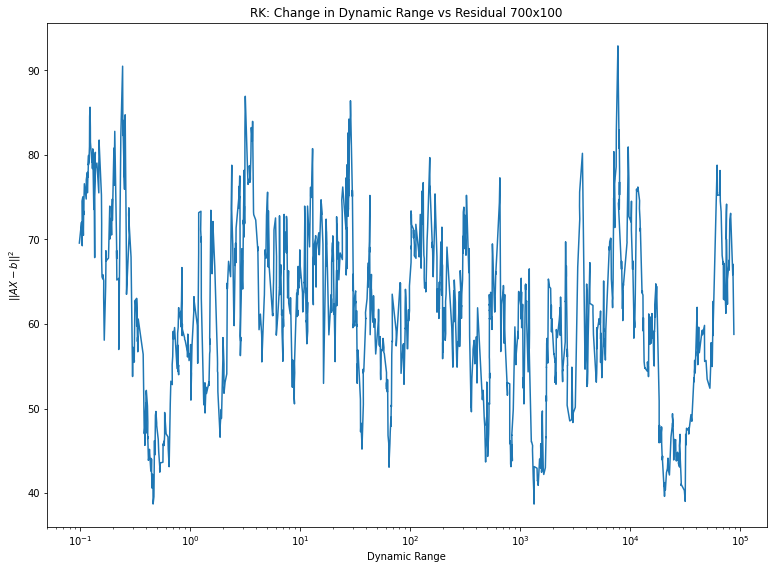

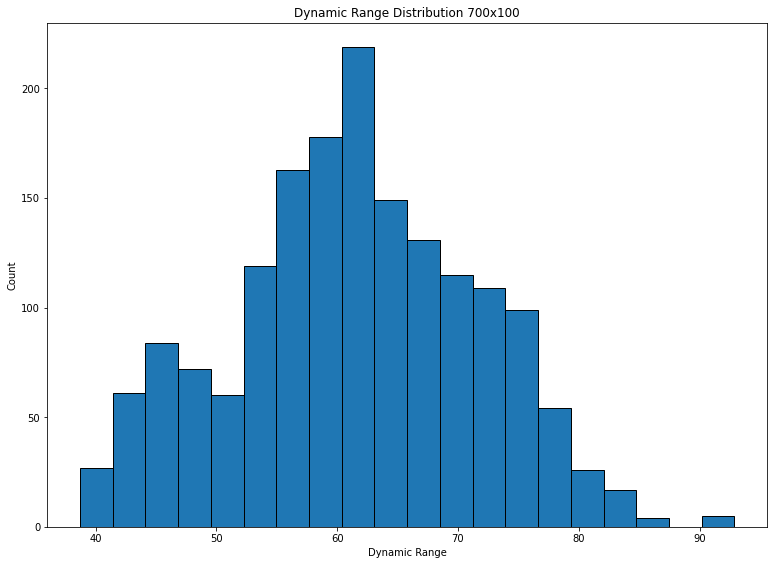

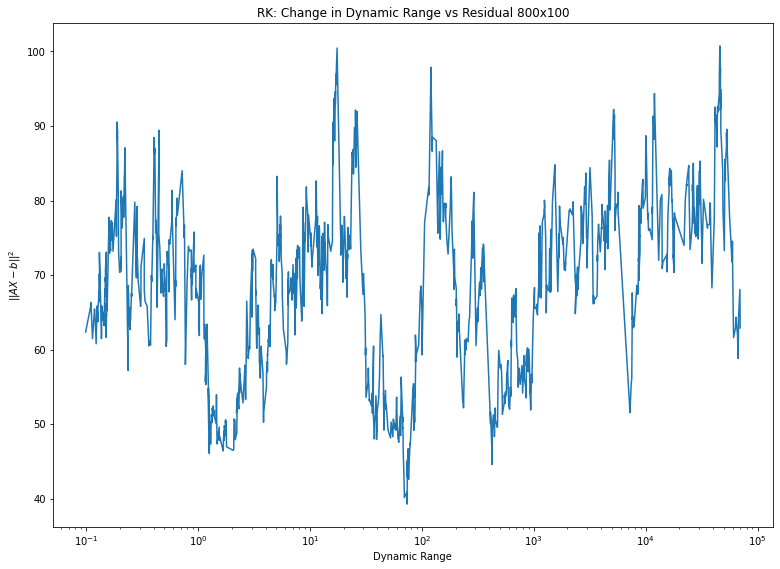

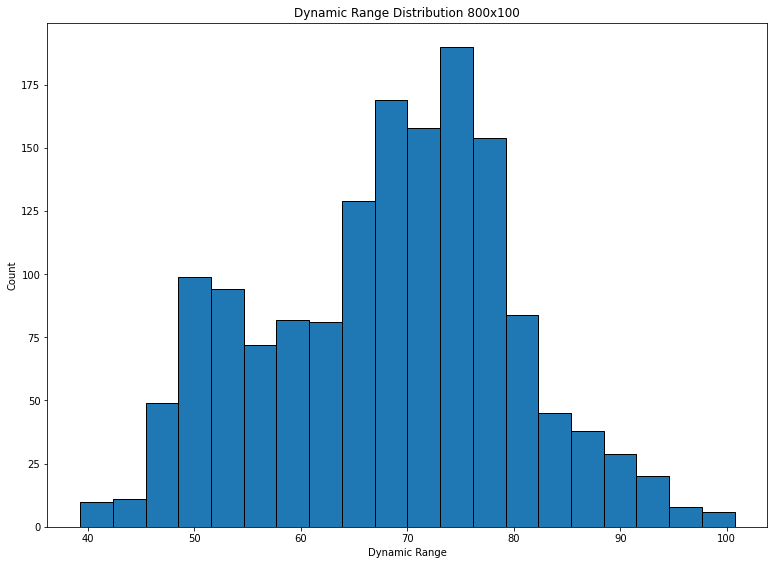

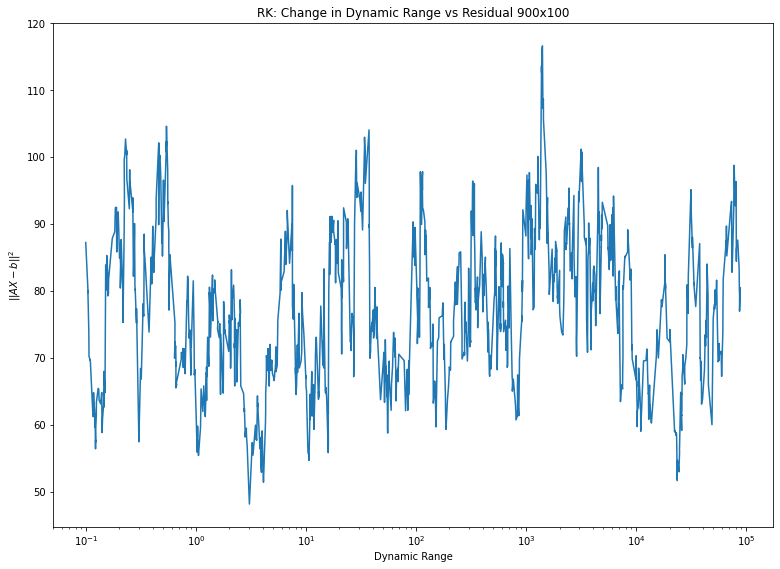

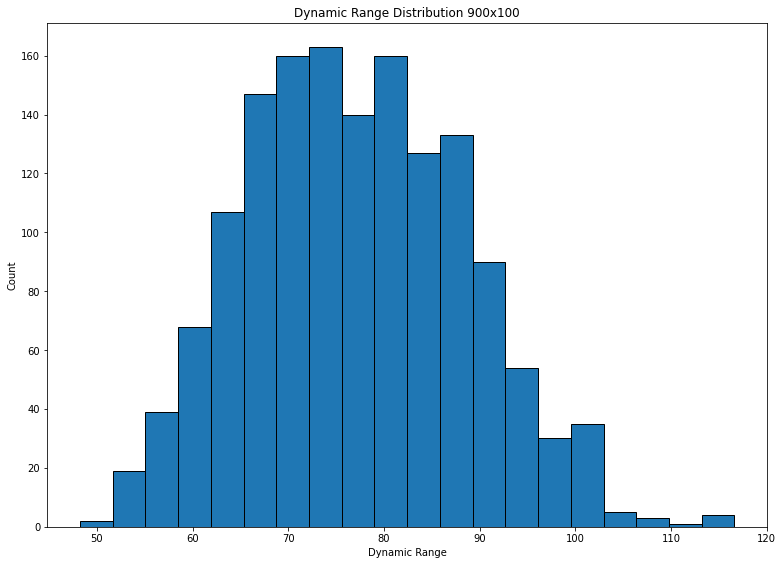

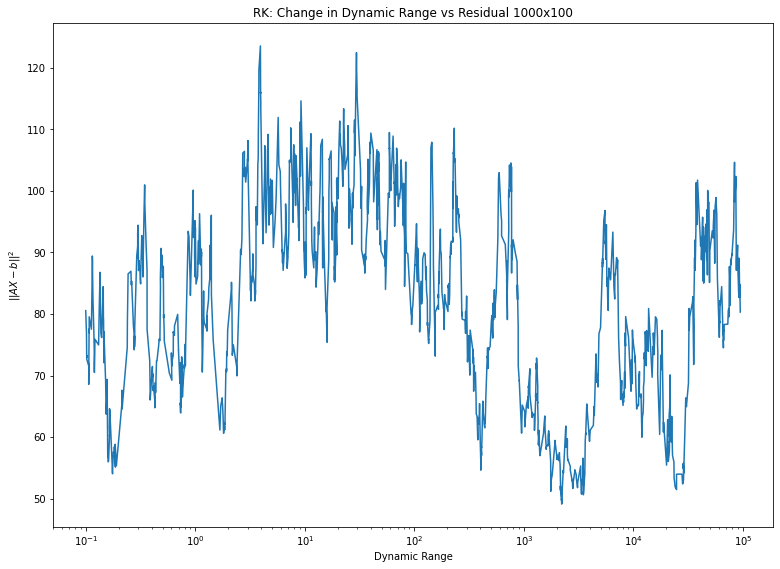

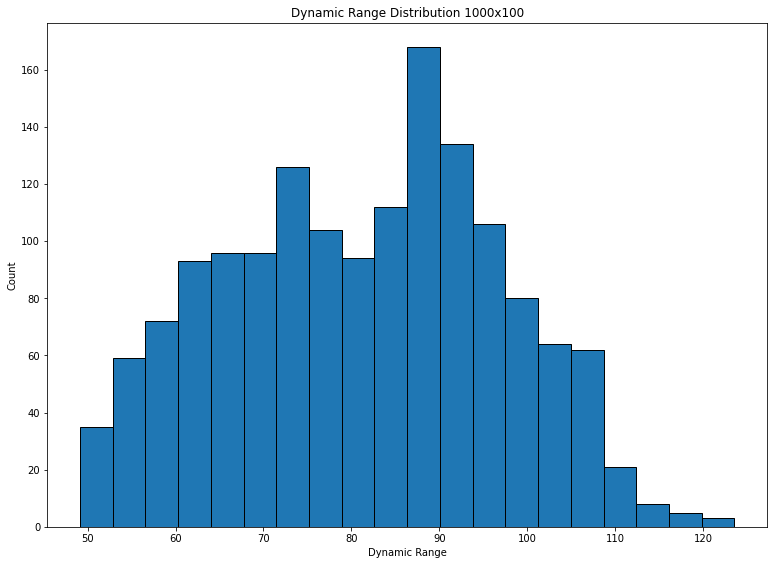

In [ ]:
min_dyn = []

for i in [[500,100],[600,100],[700,100],[800,100],[900,100], [1000,100]]:
  A = np.random.randn(i[0],i[1])
  x = np.random.randn(i[1])
  b = A @ x
  X0 = np.zeros(i[1])

  RK_result = kacz_rand(A,b,X0,x,0.1)
  dyn_range = []
  for j in range(RK_result[2]):
    dyn_range.append(LA.norm(RK_result[4][j])**2 / max(np.abs(RK_result[4][j])**2))

  fig = plt.figure(figsize =(10, 7))
  ax = fig.add_axes([0, 0, 1, 1])
  plt.semilogx(RK_result[1],dyn_range)
  plt.xlabel("Dynamic Range")
  plt.ylabel("$||AX-b||^2$")
  plt.title("RK: Change in Dynamic Range vs Residual " + str(i[0]) + "x" + str(i[1]))
  plt.show()

  min_dyn.append(min(dyn_range))
  fig = plt.figure(figsize =(10, 7))
  ax = fig.add_axes([0, 0, 1, 1])
  plt.hist(dyn_range, edgecolor = "black", bins = 20)
  plt.title("Dynamic Range Distribution " + str(i[0]) + "x" + str(i[1]))
  plt.xlabel("Dynamic Range")
  plt.ylabel("Count")
  plt.show()

Doing the same approach as the first experiment: Grabbing the dynamic range distribution of all data that have norm residual $\leq$ 10000

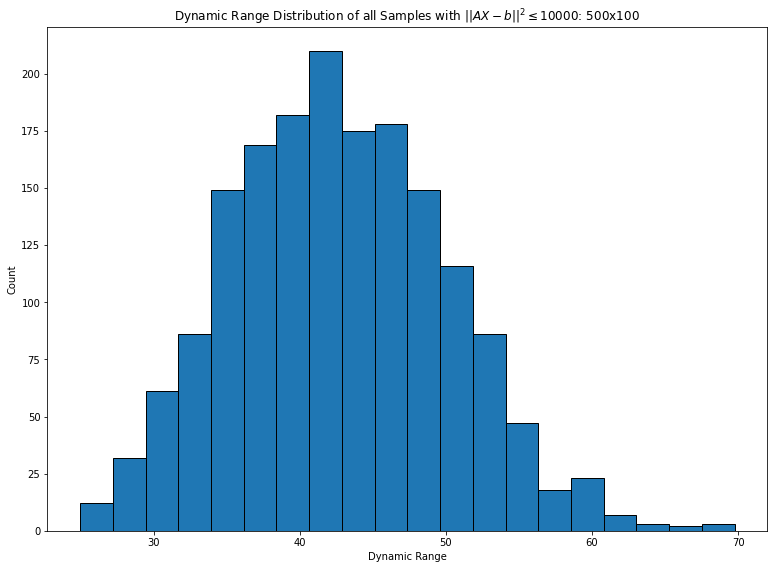

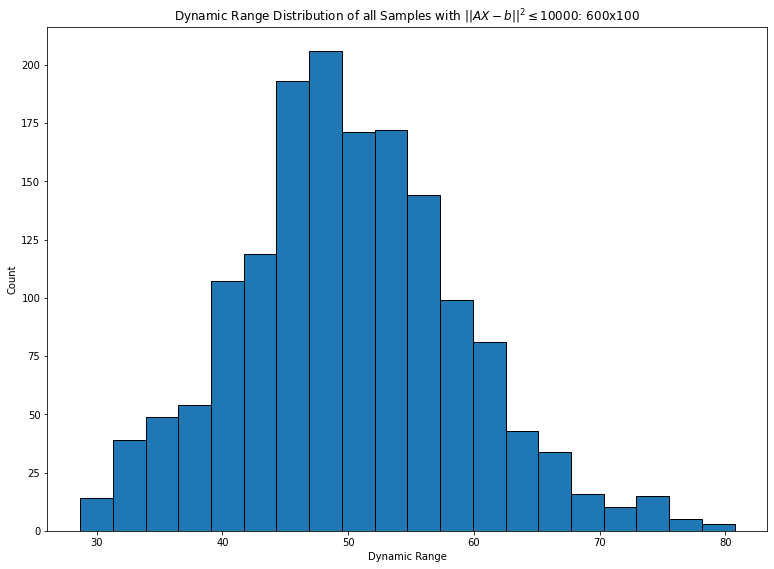

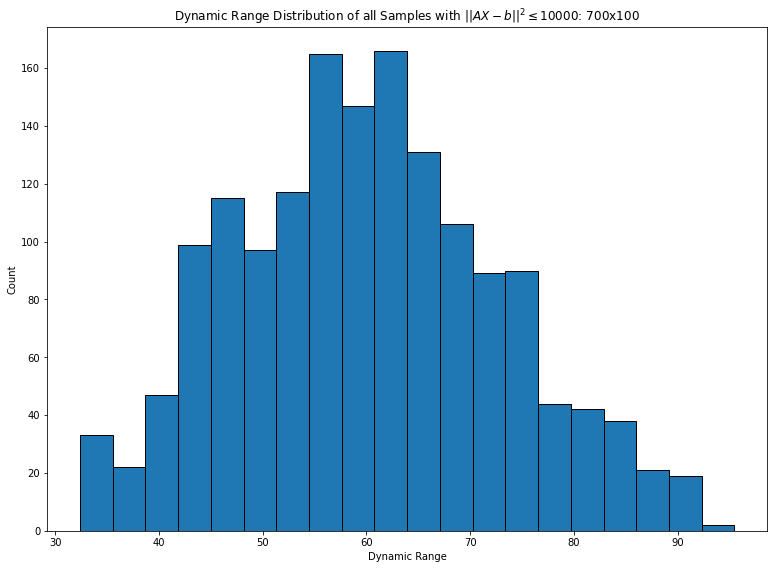

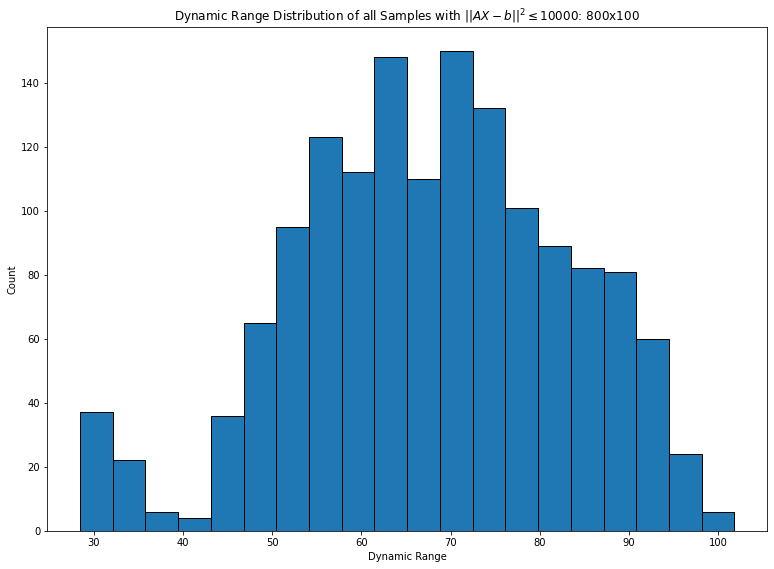

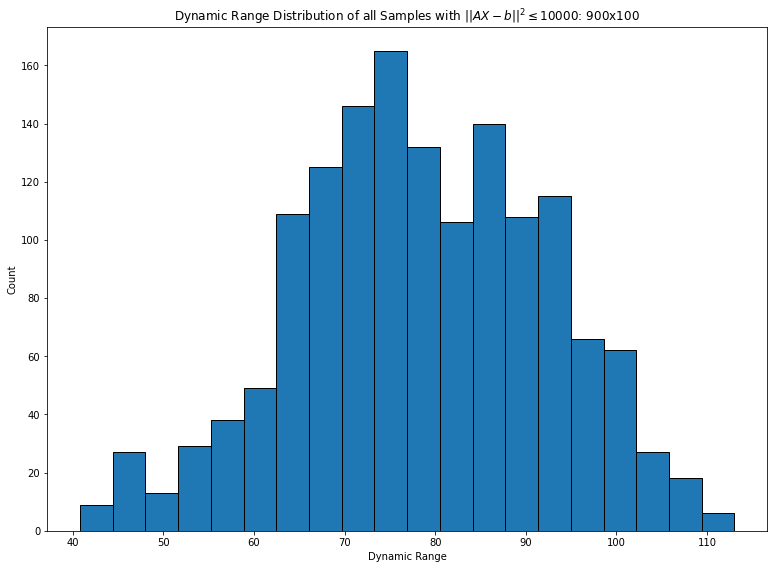

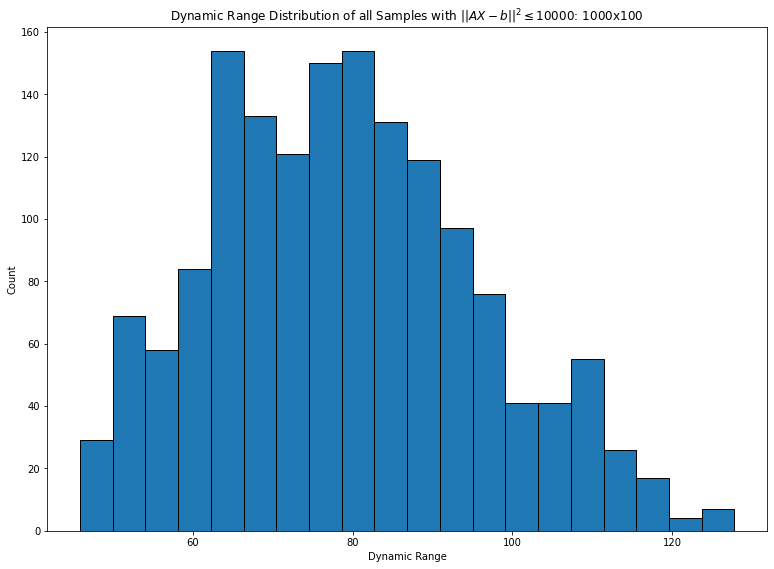

In [ ]:
for i in [[500,100],[600,100],[700,100],[800,100],[900,100], [1000,100]]:
  A = np.random.randn(i[0],i[1])
  x = np.random.randn(i[1])
  b = A @ x
  X0 = np.zeros(i[1])

  RK_result = kacz_rand(A,b,X0,x,0.1)
  norm_residual = RK_result[1]
  iteration = RK_result[2]
  residual = RK_result[4]
  new_residual_list = []
  for j in range(iteration):
    if norm_residual[j] <= 10000:
      new_residual_list.append(residual[j])
  dyn_range = []
  for j in range(RK_result[2]):
    dyn_range.append(LA.norm(RK_result[4][j])**2 / max(np.abs(RK_result[4][j])**2))

  fig = plt.figure(figsize =(10, 7))
  ax = fig.add_axes([0, 0, 1, 1])
  plt.hist(dyn_range, edgecolor = "black", bins = 20)
  plt.title("Dynamic Range Distribution of all Samples with $||AX-b||^2 \leq 10000$: " + str(i[0]) + "x" + str(i[1]))
  plt.xlabel("Dynamic Range")
  plt.ylabel("Count")
  plt.show()

When we first looked at the dynamic range distribution of all samples, we saw that dynamic residuals seem to follow a normal distribution. If we can caluculate the mean of the distribution, then that mean can be used as the threshold value. Like the residual vector, we looked at dynamic range distribution of subset of data that had norm residual vectors that is less than or equal to 10000. Again, the dynamic residual showed noraml distributions, and seemed to have similar mean values for most of the systems we observed. The mean of dynamic range is in approximately $[40,50]$, $[50,60]$, $[60,70]$, or $[80,90]$

Suggestion:

* Dynamic range should be checked in an interval

* Check if a dynamic range is in certain interval. We will try different intervals: `dyn = [[40,50], [50,60],[60,70], [80,90]]`

In [ ]:
dynQ_error = []
dyn_error = []
dynQIter = []
dynIter = []
dynQCPU = []
dynCPU = []
dynQ_flop = []
dyn_flop = []

for TOL in [[40,50], [50,60],[60,70], [80,90]]:

  t1_start_cyclic = process_time()
  dynQ_result = dynamicQ_SKM2(A, X, b, 100, TOL, 0.1)
  t1_stop_cyclic = process_time()


  t2_start_cyclic = process_time()
  dyn_result = dynamic_SKM2(A, X, b, 100, TOL, 0.1)
  t2_stop_cyclic = process_time()

  dynQCPU.append(t1_stop_cyclic - t1_start_cyclic)
  dynQ_error.append(dynQ_result[6])
  dynQIter.append(dynQ_result[2])
  dynQ_flop.append(calc_FLOP(dynQ_result[2], dynQ_result[5], m, n + m))

  dynCPU.append(t2_stop_cyclic - t2_start_cyclic)
  dyn_error.append(dyn_result[6])
  dynIter.append(dyn_result[2])
  dyn_flop.append(calc_FLOP(dyn_result[2], dyn_result[5], m, 100*m + m))

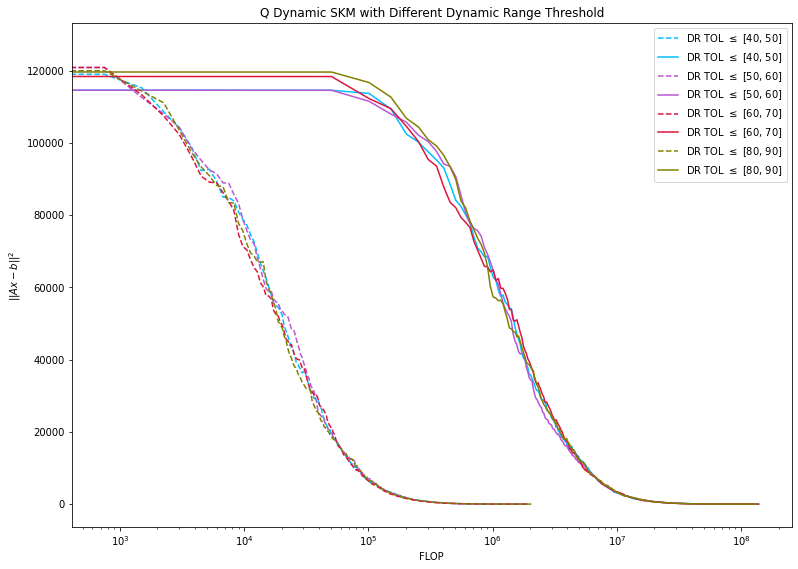

In [ ]:
# Compre: FLOP (Different Dynamic Range threshold)
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
dynTOL = [[40,50], [50,60],[60,70], [80,90]]
c = ["deepskyblue","mediumorchid","crimson","olive"]
for i in range(4):
  plt.semilogx(dynQ_flop[i], dynQ_error[i], linestyle='dashed', color = c[i], label = f"DR TOL $\leq$ {dynTOL[i]}")
  plt.semilogx(dyn_flop[i], dyn_error[i], color = c[i], label = f"DR TOL $\leq$ {dynTOL[i]}")
plt.legend()
plt.title("Q Dynamic SKM with Different Dynamic Range Threshold")
plt.xlabel("FLOP")
plt.ylabel("$||Ax - b||^2$")
plt.show()

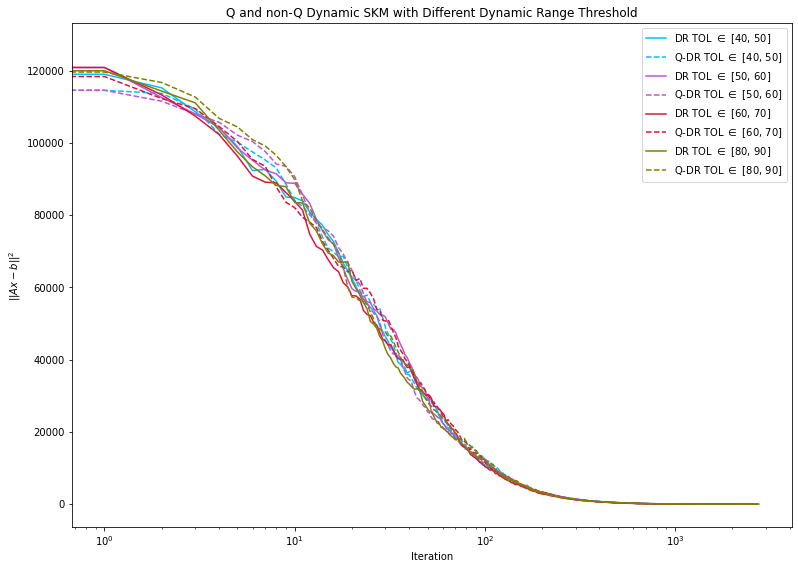

In [ ]:
# Compre: Iteration (Different Dynamic Range threshold)
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
dynTOL = [[40,50], [50,60],[60,70], [80,90]]
c = ["deepskyblue","mediumorchid","crimson","olive"]
for i in range(4):
  plt.semilogx(list(range(dynQIter[i]+1)), dynQ_error[i], color = c[i], label = f"DR TOL $\in$ {dynTOL[i]}")
  plt.semilogx(list(range(dynIter[i]+1)), dyn_error[i], linestyle='dashed', color = c[i], label = f"Q-DR TOL $\in$ {dynTOL[i]}")
plt.legend()
plt.title("Q and non-Q Dynamic SKM with Different Dynamic Range Threshold")
plt.xlabel("Iteration")
plt.ylabel("$||Ax - b||^2$")
plt.show()

# Comparing Dynamic and Residual SKM

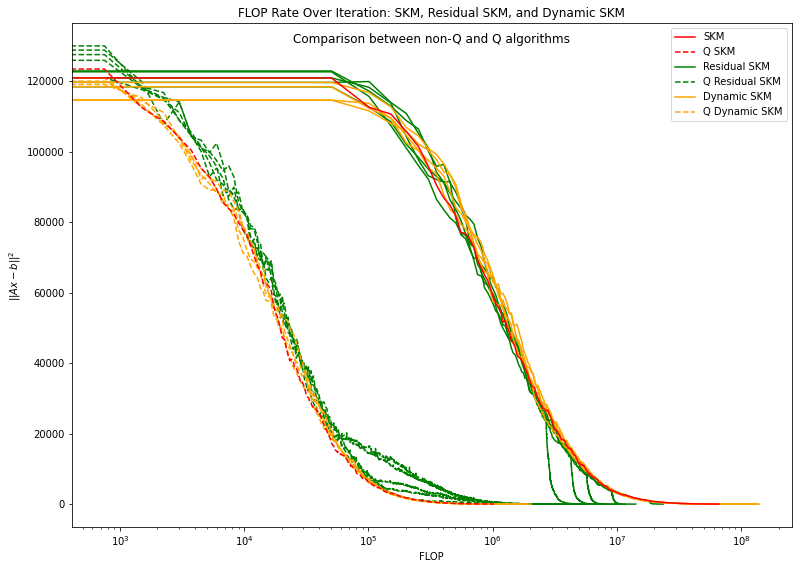

In [ ]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
handles, labels = plt.gca().get_legend_handles_labels()
for i in range(5):
  plt.semilogx(resid_flop[i], resid_error[i], color='green')
  plt.semilogx(residQ_flop[i], residQ_error[i], color = 'green', linestyle='dashed')
for i in range(4):
  plt.semilogx(dyn_flop[i], dyn_error[i], color = 'orange')
  plt.semilogx(dynQ_flop[i], dynQ_error[i], color = 'orange', linestyle = 'dashed')
plt.semilogx(SKM_flop, SKM_error, color = 'red')
plt.semilogx(SKMQ_flop, SKMQ_error, color = 'red', linestyle = 'dashed')
p1 = Line2D([0], [0], label= 'Residual SKM', color='green')
p2 = Line2D([0], [0], label='Q Residual SKM', color='green', linestyle = 'dashed')
p3 = Line2D([0], [0], label='Dynamic SKM', color='orange')
p4 = Line2D([0], [0], label='Q Dynamic SKM', color='orange', linestyle = 'dashed')
p5 = Line2D([0], [0], label='SKM', color='red')
p6 = Line2D([0], [0], label='Q SKM', color='red', linestyle = 'dashed')
handles.extend([p5, p6, p1,p2,p3,p4])
plt.legend(handles=handles)
plt.title("FLOP Rate Over Iteration: SKM, Residual SKM, and Dynamic SKM")
plt.suptitle("Comparison between non-Q and Q algorithms")
plt.xlabel("FLOP")
plt.ylabel("$||Ax-b||^2$")
plt.show()

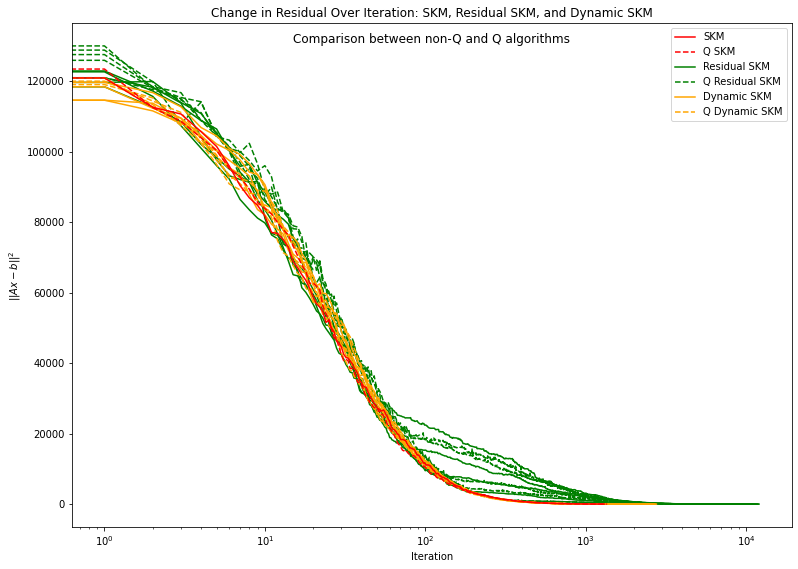

In [ ]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
handles, labels = plt.gca().get_legend_handles_labels()
for i in range(5):
  plt.semilogx(range(residIter[i]+1), resid_error[i], color='green')
  plt.semilogx(range(residQIter[i]+1), residQ_error[i], color = 'green', linestyle='dashed')
for i in range(4):
  plt.semilogx(range(dynIter[i]+1), dyn_error[i], color = 'orange')
  plt.semilogx(range(dynQIter[i]+1), dynQ_error[i], color = 'orange', linestyle = 'dashed')
plt.semilogx(range(SKMIter+1), SKM_error, color = 'red')
plt.semilogx(range(SKMQIter+1), SKMQ_error, color = 'red', linestyle = 'dashed')
p1 = Line2D([0], [0], label= 'Residual SKM', color='green')
p2 = Line2D([0], [0], label='Q Residual SKM', color='green', linestyle = 'dashed')
p3 = Line2D([0], [0], label='Dynamic SKM', color='orange')
p4 = Line2D([0], [0], label='Q Dynamic SKM', color='orange', linestyle = 'dashed')
p5 = Line2D([0], [0], label='SKM', color='red')
p6 = Line2D([0], [0], label='Q SKM', color='red', linestyle = 'dashed')
handles.extend([p5, p6, p1,p2,p3,p4])
plt.legend(handles=handles)
plt.title("Change in Residual Over Iteration: SKM, Residual SKM, and Dynamic SKM")
plt.suptitle("Comparison between non-Q and Q algorithms")
plt.xlabel("Iteration")
plt.ylabel("$||Ax-b||^2$")
plt.show()

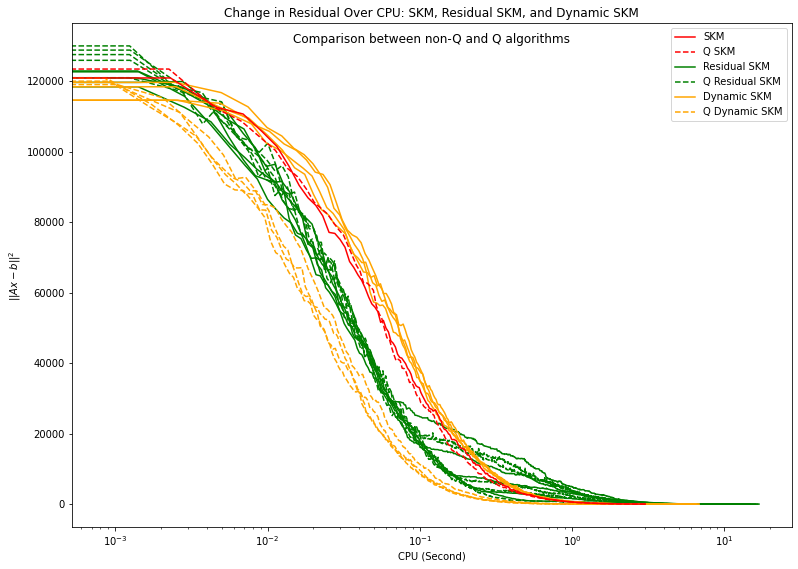

In [ ]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
handles, labels = plt.gca().get_legend_handles_labels()
for i in range(5):
  plt.semilogx(np.linspace(0,residCPU[i],residIter[i]+1), resid_error[i], color='green')
  plt.semilogx(np.linspace(0,residQCPU[i],residQIter[i]+1), residQ_error[i], color = 'green', linestyle='dashed')
for i in range(4):
  plt.semilogx(np.linspace(0,dynCPU[i],dynIter[i]+1), dyn_error[i], color = 'orange')
  plt.semilogx(np.linspace(0,dynQCPU[i],dynQIter[i]+1), dynQ_error[i], color = 'orange', linestyle = 'dashed')
plt.semilogx(np.linspace(0,SKM_CPU,SKMIter+1), SKM_error, color = 'red')
plt.semilogx(np.linspace(0,SKMQ_CPU,SKMQIter+1), SKMQ_error, color = 'red', linestyle = 'dashed')
p1 = Line2D([0], [0], label= 'Residual SKM', color='green')
p2 = Line2D([0], [0], label='Q Residual SKM', color='green', linestyle = 'dashed')
p3 = Line2D([0], [0], label='Dynamic SKM', color='orange')
p4 = Line2D([0], [0], label='Q Dynamic SKM', color='orange', linestyle = 'dashed')
p5 = Line2D([0], [0], label='SKM', color='red')
p6 = Line2D([0], [0], label='Q SKM', color='red', linestyle = 'dashed')
handles.extend([p5, p6, p1,p2,p3,p4])
plt.legend(handles=handles)
plt.title("Change in Residual Over CPU: SKM, Residual SKM, and Dynamic SKM")
plt.suptitle("Comparison between non-Q and Q algorithms")
plt.xlabel("CPU (Second)")
plt.ylabel("$||Ax-b||^2$")
plt.show()

Choose the best set of parameters from each subset of data

# Experiment 3: Efficiency Test